### Линейная комбинация.Прогноз размещения в месяц на площадке (регионы)

In [55]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [56]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
#Немоного изменим параметры вывода графиков
rcParams['figure.figsize'] = 18,10

In [57]:
data = pd.read_excel('Регионы.xlsx')
data.head()

,RegCode,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,M27,M28,M29,M30,M31,M32,M33,M34,M35,M36
0,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,8,3,4,0,0
1,2,0,1,6,1,2,7,19,13,13,...,46,31,80,140,421,551,781,212,0,0
2,3,73,318,356,370,428,421,281,306,209,...,358,326,453,377,368,493,295,108,0,0
3,4,34,218,210,195,256,263,265,268,284,...,305,350,350,348,199,370,280,73,0,0
4,5,20,336,550,582,598,609,438,534,406,...,487,659,551,599,371,287,225,78,0,0


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 37 columns):
RegCode    84 non-null int64
M1         84 non-null int64
M2         84 non-null int64
M3         84 non-null int64
M4         84 non-null int64
M5         84 non-null int64
M6         84 non-null int64
M7         84 non-null int64
M8         84 non-null int64
M9         84 non-null int64
M10        84 non-null int64
M11        84 non-null int64
M12        84 non-null int64
M13        84 non-null int64
M14        84 non-null int64
M15        84 non-null int64
M16        84 non-null int64
M17        84 non-null int64
M18        84 non-null int64
M19        84 non-null int64
M20        84 non-null int64
M21        84 non-null int64
M22        84 non-null int64
M23        84 non-null int64
M24        84 non-null int64
M25        84 non-null int64
M26        84 non-null int64
M27        84 non-null int64
M28        84 non-null int64
M29        84 non-null int64
M30        84 non-null int6

In [59]:
melt = data.melt(id_vars='RegCode', var_name='Month', value_name='Proc')

melt['Month'] = melt['Month'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['RegCode', 'Month'])
melt.head()

,RegCode,Month,Proc
0,1,1,0
84,1,2,0
168,1,3,0
252,1,4,1
336,1,5,0


In [60]:
month_start=29
month_end=34
s='Procedures (week '+str(month_start)+ ' - '+str(month_end)+ ')'

In [61]:
import copy

In [62]:
melt2 =  melt.copy()
melt2['Last_Month_Proc'] = melt2.groupby(['RegCode'])['Proc'].shift()
melt2['Last_Month_Diff'] = melt2.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt2 = melt2.dropna()
melt2.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff
168,1,3,0,0.0,0.0
252,1,4,1,0.0,0.0
336,1,5,0,1.0,1.0
420,1,6,0,0.0,-1.0
504,1,7,0,0.0,0.0


In [63]:
procedures = []
for Month in range(0, month_start):
    val=melt[melt['Month'] == Month]
    total=sum(val['Proc'])
    procedures.append(total)

In [64]:
proceduresAll = []
for Month in range(0,month_end):
    val=melt[melt['Month'] == Month]
    total=sum(val['Proc'])
    proceduresAll.append(total)

In [65]:
melt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2856 entries, 168 to 3023
Data columns (total 5 columns):
RegCode            2856 non-null int64
Month              2856 non-null int32
Proc               2856 non-null int64
Last_Month_Proc    2856 non-null float64
Last_Month_Diff    2856 non-null float64
dtypes: float64(2), int32(1), int64(2)
memory usage: 122.7 KB


In [66]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [67]:
%%time
mean_errorB = []
total_errorB = []
ProcB = copy.copy(procedures)
predict_ProcB = copy.copy(procedures)
abs_pr_errorB = []
for Month in range(month_start, month_end):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    yts=val['Proc']
    
    p = val['Last_Month_Proc'].values
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (Month, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorB.append(error)
    total_errorB.append(abs_error)
    ProcB.append(total_yts)
    predict_ProcB.append(total_p)
    abs_pr_errorB.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error = %.5f' % np.mean(total_errorB))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorB))

Month 29 - Error 0.31749, Real Total 43153.0 - Predict Total 42918.0, Abs Error 235.0, Persent - 0.5
Month 30 - Error 0.31373, Real Total 44140.0 - Predict Total 43153.0, Abs Error 987.0, Persent - 2.2
Month 31 - Error 0.52860, Real Total 32364.0 - Predict Total 44140.0, Abs Error 11776.0, Persent - 36.4
Month 32 - Error 0.52518, Real Total 40762.0 - Predict Total 32364.0, Abs Error 8398.0, Persent - 20.6
Month 33 - Error 0.43206, Real Total 33636.0 - Predict Total 40762.0, Abs Error 7126.0, Persent - 21.2
Mean Error = 0.42341
Mean Abs Error = 5704.40000
Mean Abs Error persent = 16.19098
Wall time: 16 ms


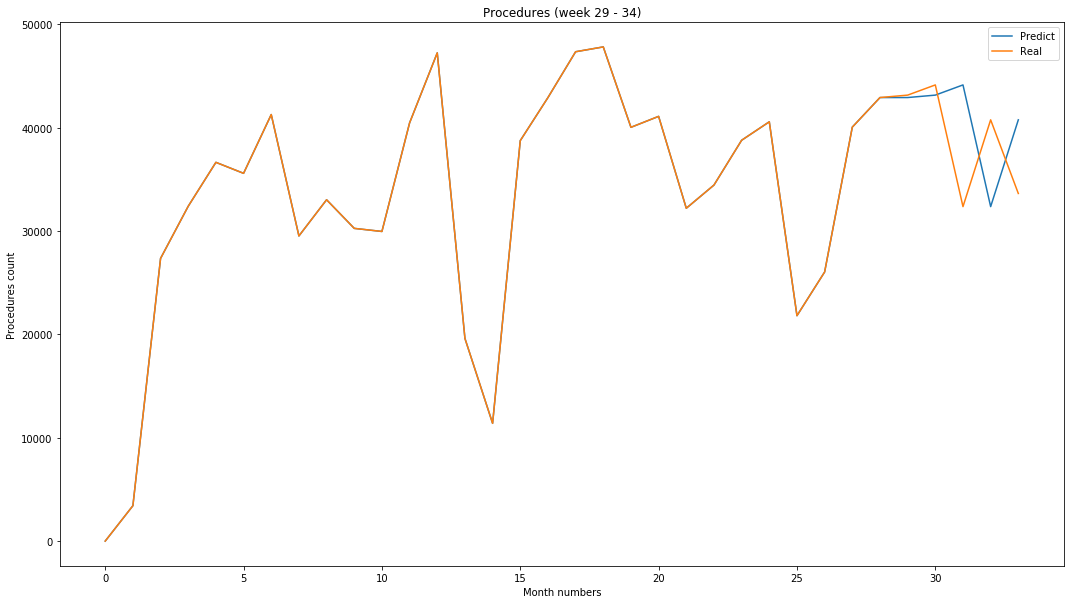

In [68]:

plt.plot(predict_ProcB)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

(20000, 50000)

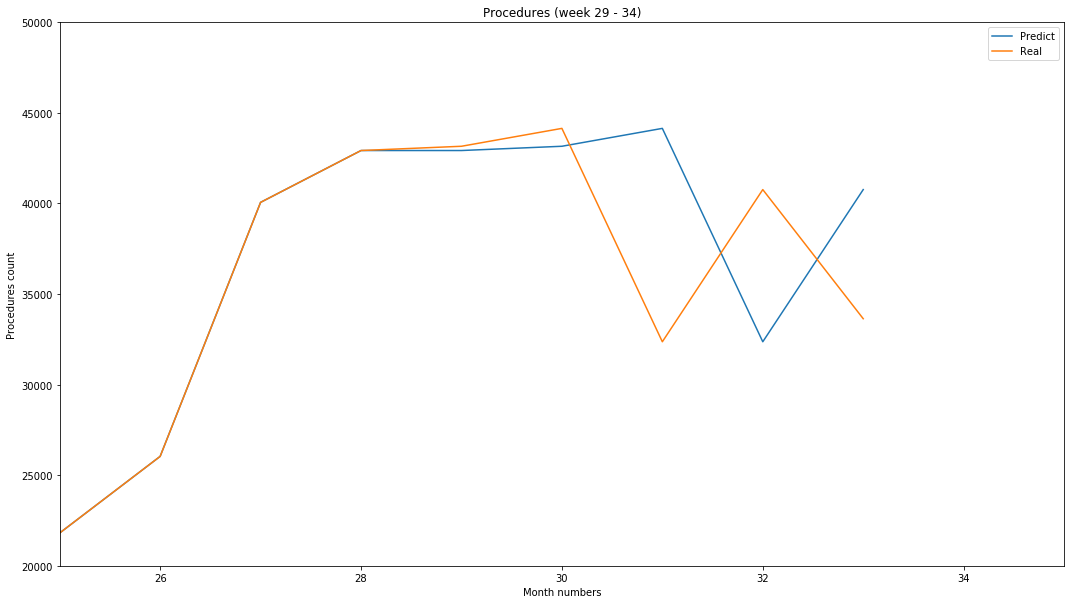

In [69]:
plt.plot(predict_ProcB)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

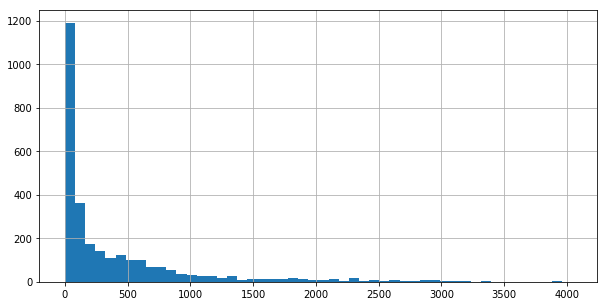

In [70]:
melt2['Proc'].hist(bins=50, figsize=(10,5))

In [71]:
%%time
mean_errorLR2 = []
mean_errorRF2 = []
mean_errorGB2 = []

mean_errorEC2 = []


total_errorLR2 = []
predict_ProcLR2 = copy.copy(procedures)
abs_pr_errorLR2 = []

total_errorRF2 = []
predict_ProcRF2 = copy.copy(procedures)
abs_pr_errorRF2 = []

total_errorGB2 = []
predict_ProcGB2 = copy.copy(procedures)
abs_pr_errorGB2 = []

total_errorEC2 = []
predict_ProcEC2 = copy.copy(procedures)
abs_pr_errorEC2 = []
for Month in range(month_start, month_end):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR2 = rmsle(yts, plr)
    abs_errorLR2 = abs(total_yts-total_plr)
    abs_prLR2 = abs_errorLR2/total_yts*100
    
    mean_errorLR2.append(errorLR2)
    total_errorLR2.append(abs_errorLR2)
    predict_ProcLR2.append(total_plr)
    abs_pr_errorLR2.append(abs_prLR2)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF2 = rmsle(yts, prf)
    abs_errorRF2 = abs(total_yts-total_prf)
    abs_prRF2 = abs_errorRF2/total_yts*100
    
    mean_errorRF2.append(errorRF2)
    total_errorRF2.append(abs_errorRF2)
    predict_ProcRF2.append(total_prf)
    abs_pr_errorRF2.append(abs_prRF2)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB2 = rmsle(yts, pgb)
    abs_errorGB2 = abs(total_yts-total_pgb)
    abs_prGB2 = abs_errorGB2/total_yts*100
    
    mean_errorGB2.append(errorGB2)
    total_errorGB2.append(abs_errorGB2)
    predict_ProcGB2.append(total_pgb)
    abs_pr_errorGB2.append(abs_prGB2)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC2=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC2)

    errorEC2 = rmsle(yts, pEC2)
    abs_errorEC2 = abs(total_yts-total_pec)
    abs_prEC2 = abs_errorEC2/total_yts*100
    
    mean_errorEC2.append(errorEC2)
    total_errorEC2.append(abs_errorEC2)
    predict_ProcEC2.append(total_pec)
    abs_pr_errorEC2.append(abs_prEC2)
    print('Month %d' % (Month))
    print('LR2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR2, total_yts, total_plr, abs_errorLR2, abs_prLR2))
    print('RF2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF2, total_yts, total_prf, abs_errorRF2, abs_prRF2))
    print('GB2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB2, total_yts, total_pgb, abs_errorGB2, abs_prGB2))
    print('EC2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC2, total_yts, total_pec, abs_errorEC2, abs_prEC2))
print('Mean Error')
print('LR2 = %.5f, RF2 = %.5f, GB2 = %.5f, EC2 = %.5f' % (np.mean(mean_errorLR2), np.mean(mean_errorRF2), np.mean(mean_errorGB2), np.mean(mean_errorEC2)))
print('Mean Abs Error')
print('LR2 = %.1f, RF2 = %.1f, GB2 = %.1f, EC2 = %.1f' % (np.mean(total_errorLR2), np.mean(total_errorRF2), np.mean(total_errorGB2), np.mean(total_errorEC2)))
print('Mean Abs Error persent')
print('LR2 = %.1f, RF2 = %.1f, GB2 = %.1f, EC2 = %.1f' % (np.mean(abs_pr_errorLR2), np.mean(abs_pr_errorRF2), np.mean(abs_pr_errorGB2), np.mean(abs_pr_errorEC2)))

Month 29
LR2 - Error 0.81437, Real Total 43153.0 - Predict Total 42649.1, Abs Error 503.9, Persent - 1.2
RF2 - Error 0.37549, Real Total 43153.0 - Predict Total 43367.6, Abs Error 214.6, Persent - 0.5
GB2 - Error 0.34948, Real Total 43153.0 - Predict Total 44135.0, Abs Error 982.0, Persent - 2.3
EC2 - Error 0.60411, Real Total 43153.0 - Predict Total 43383.9, Abs Error 230.9, Persent - 0.5
Month 30
LR2 - Error 0.76113, Real Total 44140.0 - Predict Total 43156.6, Abs Error 983.4, Persent - 2.2
RF2 - Error 0.34581, Real Total 44140.0 - Predict Total 42587.1, Abs Error 1552.9, Persent - 3.5
GB2 - Error 0.31763, Real Total 44140.0 - Predict Total 41884.1, Abs Error 2255.9, Persent - 5.1
EC2 - Error 0.55011, Real Total 44140.0 - Predict Total 42542.6, Abs Error 1597.4, Persent - 3.6
Month 31
LR2 - Error 1.00577, Real Total 32364.0 - Predict Total 44155.4, Abs Error 11791.4, Persent - 36.4
RF2 - Error 0.59371, Real Total 32364.0 - Predict Total 43392.5, Abs Error 11028.5, Persent - 34.1
GB2 

(20000, 50000)

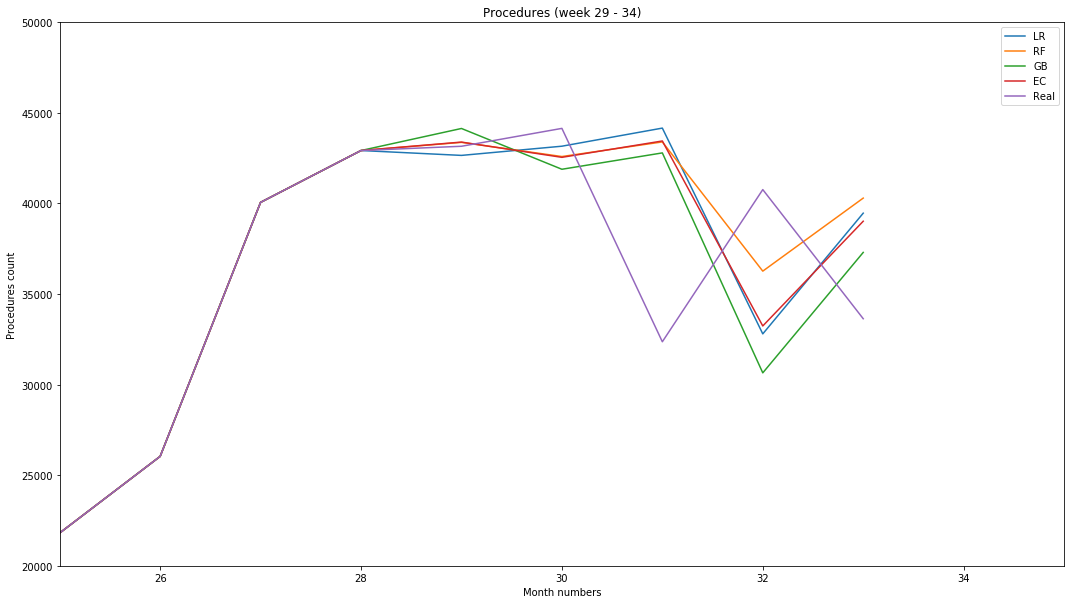

In [72]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF2)
plt.plot(predict_ProcGB2)
plt.plot(predict_ProcEC2)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

In [73]:
melt3 = melt.copy()
melt3['Last_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt3['Last-1_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt3 = melt3.dropna()
melt3.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff
252,1,4,1,0.0,0.0,0.0,0.0
336,1,5,0,1.0,1.0,0.0,0.0
420,1,6,0,0.0,-1.0,1.0,1.0
504,1,7,0,0.0,0.0,0.0,-1.0
588,1,8,1,0.0,0.0,0.0,0.0


In [74]:
%%time
mean_errorLR3 = []
mean_errorRF3 = []
mean_errorGB3 = []

mean_errorEC3 = []


total_errorLR3 = []
predict_ProcLR3 = copy.copy(procedures)
abs_pr_errorLR3 = []

total_errorRF3 = []
predict_ProcRF3 = copy.copy(procedures)
abs_pr_errorRF3 = []

total_errorGB3 = []
predict_ProcGB3 = copy.copy(procedures)
abs_pr_errorGB3 = []

total_errorEC3 = []
predict_ProcEC3 = copy.copy(procedures)
abs_pr_errorEC3 = []
for Month in range(month_start, month_end):
    train = melt3[melt3['Month'] < Month]
    val = melt3[melt3['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR3 = rmsle(yts, plr)
    abs_errorLR3 = abs(total_yts-total_plr)
    abs_prLR3 = abs_errorLR3/total_yts*100
    
    mean_errorLR3.append(errorLR3)
    total_errorLR3.append(abs_errorLR3)
    predict_ProcLR3.append(total_plr)
    abs_pr_errorLR3.append(abs_prLR3)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF3 = rmsle(yts, prf)
    abs_errorRF3 = abs(total_yts-total_prf)
    abs_prRF3 = abs_errorRF3/total_yts*100
    
    mean_errorRF3.append(errorRF3)
    total_errorRF3.append(abs_errorRF3)
    predict_ProcRF3.append(total_prf)
    abs_pr_errorRF3.append(abs_prRF3)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB3 = rmsle(yts, pgb)
    abs_errorGB3 = abs(total_yts-total_pgb)
    abs_prGB3 = abs_errorGB3/total_yts*100
    
    mean_errorGB3.append(errorGB3)
    total_errorGB3.append(abs_errorGB3)
    predict_ProcGB3.append(total_pgb)
    abs_pr_errorGB3.append(abs_prGB3)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC3=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC3)

    errorEC3 = rmsle(yts, pEC3)
    abs_errorEC3 = abs(total_yts-total_pec)
    abs_prEC3 = abs_errorEC3/total_yts*100
    
    mean_errorEC3.append(errorEC3)
    total_errorEC3.append(abs_errorEC3)
    predict_ProcEC3.append(total_pec)
    abs_pr_errorEC3.append(abs_prEC3)
    print('Month %d' % (Month))
    print('LR3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR3, total_yts, total_plr, abs_errorLR3, abs_prLR3))
    print('RF3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF3, total_yts, total_prf, abs_errorRF3, abs_prRF3))
    print('GB3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB3, total_yts, total_pgb, abs_errorGB3, abs_prGB3))
    print('EC3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC3, total_yts, total_pec, abs_errorEC3, abs_prEC3))
print('Mean Error')
print('LR3 = %.5f, RF3 = %.5f, GB3 = %.5f, EC3 = %.5f' % (np.mean(mean_errorLR3), np.mean(mean_errorRF3), np.mean(mean_errorGB3), np.mean(mean_errorEC3)))
print('Mean Abs Error')
print('LR3 = %.1f, RF3 = %.1f, GB3 = %.1f, EC3 = %.1f' % (np.mean(total_errorLR3), np.mean(total_errorRF3), np.mean(total_errorGB3), np.mean(total_errorEC3)))
print('Mean Abs Error persent')
print('LR3 = %.1f, RF3 = %.1f, GB3 = %.1f, EC3 = %.1f' % (np.mean(abs_pr_errorLR3), np.mean(abs_pr_errorRF3), np.mean(abs_pr_errorGB3), np.mean(abs_pr_errorEC3)))

Month 29
LR3 - Error 0.61332, Real Total 43153.0 - Predict Total 37444.1, Abs Error 5708.9, Persent - 13.2
RF3 - Error 0.34001, Real Total 43153.0 - Predict Total 40349.7, Abs Error 2803.3, Persent - 6.5
GB3 - Error 0.33905, Real Total 43153.0 - Predict Total 43221.5, Abs Error 68.5, Persent - 0.2
EC3 - Error 0.44305, Real Total 43153.0 - Predict Total 40338.4, Abs Error 2814.6, Persent - 6.5
Month 30
LR3 - Error 0.64496, Real Total 44140.0 - Predict Total 42568.5, Abs Error 1571.5, Persent - 3.6
RF3 - Error 0.32413, Real Total 44140.0 - Predict Total 42202.4, Abs Error 1937.6, Persent - 4.4
GB3 - Error 0.32644, Real Total 44140.0 - Predict Total 44474.4, Abs Error 334.4, Persent - 0.8
EC3 - Error 0.47307, Real Total 44140.0 - Predict Total 43081.8, Abs Error 1058.2, Persent - 2.4
Month 31
LR3 - Error 0.90207, Real Total 32364.0 - Predict Total 44393.7, Abs Error 12029.7, Persent - 37.2
RF3 - Error 0.58759, Real Total 32364.0 - Predict Total 42684.3, Abs Error 10320.3, Persent - 31.9
G

(20000, 50000)

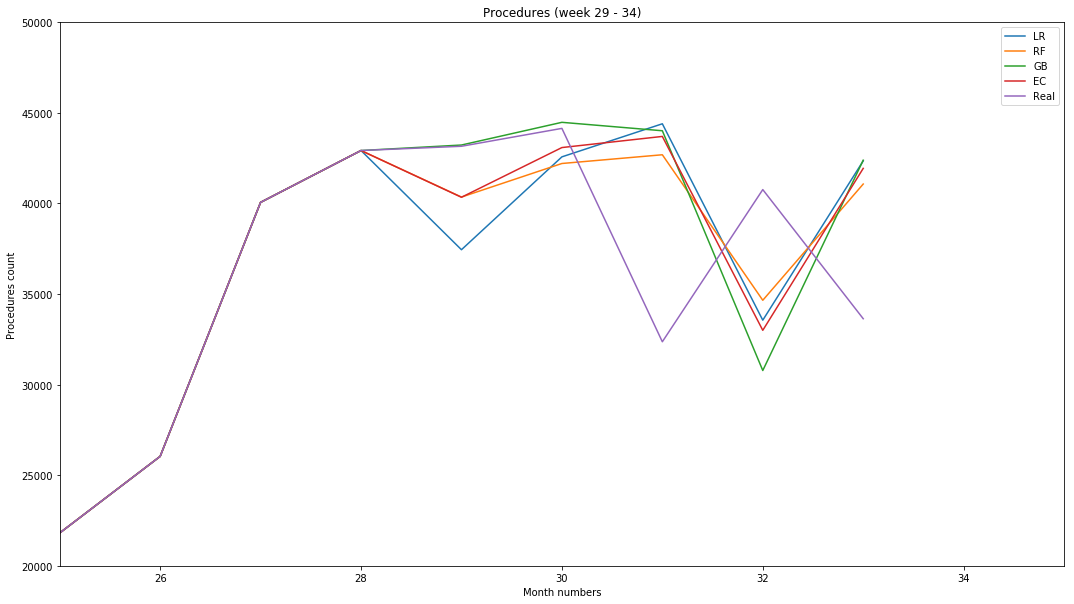

In [75]:
plt.plot(predict_ProcLR3)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcGB3)
plt.plot(predict_ProcEC3)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

In [76]:
melt4 = melt.copy()
melt4['Last_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift()
melt4['Last_Month_Diff'] = melt4.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt4['Last-1_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(2)
melt4['Last-1_Month_Diff'] = melt4.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt4['Last-2_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(3)
melt4['Last-2_Month_Diff'] = melt4.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt4 = melt4.dropna()
melt4.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff,Last-2_Month_Proc,Last-2_Month_Diff
336,1,5,0,1.0,1.0,0.0,0.0,0.0,0.0
420,1,6,0,0.0,-1.0,1.0,1.0,0.0,0.0
504,1,7,0,0.0,0.0,0.0,-1.0,1.0,1.0
588,1,8,1,0.0,0.0,0.0,0.0,0.0,-1.0
672,1,9,1,1.0,1.0,0.0,0.0,0.0,0.0


In [77]:
%%time
mean_errorLR4 = []
mean_errorRF4 = []
mean_errorGB4 = []

mean_errorEC4 = []


total_errorLR4 = []
predict_ProcLR4 = copy.copy(procedures)
abs_pr_errorLR4 = []

total_errorRF4 = []
predict_ProcRF4 = copy.copy(procedures)
abs_pr_errorRF4 = []

total_errorGB4 = []
predict_ProcGB4 = copy.copy(procedures)
abs_pr_errorGB4 = []

total_errorEC4 = []
predict_ProcEC4 = copy.copy(procedures)
abs_pr_errorEC4 = []
for Month in range(month_start, month_end):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR4 = rmsle(yts, plr)
    abs_errorLR4 = abs(total_yts-total_plr)
    abs_prLR4 = abs_errorLR4/total_yts*100
    
    mean_errorLR4.append(errorLR4)
    total_errorLR4.append(abs_errorLR4)
    predict_ProcLR4.append(total_plr)
    abs_pr_errorLR4.append(abs_prLR4)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF4 = rmsle(yts, prf)
    abs_errorRF4 = abs(total_yts-total_prf)
    abs_prRF4 = abs_errorRF4/total_yts*100
    
    mean_errorRF4.append(errorRF4)
    total_errorRF4.append(abs_errorRF4)
    predict_ProcRF4.append(total_prf)
    abs_pr_errorRF4.append(abs_prRF4)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB4 = rmsle(yts, pgb)
    abs_errorGB4 = abs(total_yts-total_pgb)
    abs_prGB4 = abs_errorGB4/total_yts*100
    
    mean_errorGB4.append(errorGB4)
    total_errorGB4.append(abs_errorGB4)
    predict_ProcGB4.append(total_pgb)
    abs_pr_errorGB4.append(abs_prGB4)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC4=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC4)

    errorEC4 = rmsle(yts, pEC4)
    abs_errorEC4 = abs(total_yts-total_pec)
    abs_prEC4 = abs_errorEC4/total_yts*100
    
    mean_errorEC4.append(errorEC4)
    total_errorEC4.append(abs_errorEC4)
    predict_ProcEC4.append(total_pec)
    abs_pr_errorEC4.append(abs_prEC4)
    print('Month %d' % (Month))
    print('LR4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR4, total_yts, total_plr, abs_errorLR4, abs_prLR4))
    print('RF4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF4, total_yts, total_prf, abs_errorRF4, abs_prRF4))
    print('GB4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB4, total_yts, total_pgb, abs_errorGB4, abs_prGB4))
    print('EC4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC4, total_yts, total_pec, abs_errorEC4, abs_prEC4))
print('Mean Error')
print('LR4 = %.5f, RF4 = %.5f, GB4 = %.5f, EC4 = %.5f' % (np.mean(mean_errorLR4), np.mean(mean_errorRF4), np.mean(mean_errorGB4), np.mean(mean_errorEC4)))
print('Mean Abs Error')
print('LR4 = %.1f, RF4 = %.1f, GB4 = %.1f, EC4 = %.1f' % (np.mean(total_errorLR4), np.mean(total_errorRF4), np.mean(total_errorGB4), np.mean(total_errorEC4)))
print('Mean Abs Error persent')
print('LR4 = %.1f, RF4 = %.1f, GB4 = %.1f, EC4 = %.1f' % (np.mean(abs_pr_errorLR4), np.mean(abs_pr_errorRF4), np.mean(abs_pr_errorGB4), np.mean(abs_pr_errorEC4)))

Month 29
LR4 - Error 0.61286, Real Total 43153.0 - Predict Total 35210.5, Abs Error 7942.5, Persent - 18.4
RF4 - Error 0.33612, Real Total 43153.0 - Predict Total 37777.4, Abs Error 5375.6, Persent - 12.5
GB4 - Error 0.34730, Real Total 43153.0 - Predict Total 39798.9, Abs Error 3354.1, Persent - 7.8
EC4 - Error 0.44095, Real Total 43153.0 - Predict Total 37595.6, Abs Error 5557.4, Persent - 12.9
Month 30
LR4 - Error 0.68297, Real Total 44140.0 - Predict Total 41202.6, Abs Error 2937.4, Persent - 6.7
RF4 - Error 0.30410, Real Total 44140.0 - Predict Total 41513.1, Abs Error 2626.9, Persent - 6.0
GB4 - Error 0.33160, Real Total 44140.0 - Predict Total 44227.6, Abs Error 87.6, Persent - 0.2
EC4 - Error 0.49596, Real Total 44140.0 - Predict Total 42314.4, Abs Error 1825.6, Persent - 4.1
Month 31
LR4 - Error 0.97171, Real Total 32364.0 - Predict Total 44947.4, Abs Error 12583.4, Persent - 38.9
RF4 - Error 0.59879, Real Total 32364.0 - Predict Total 42373.2, Abs Error 10009.2, Persent - 30.

(20000, 50000)

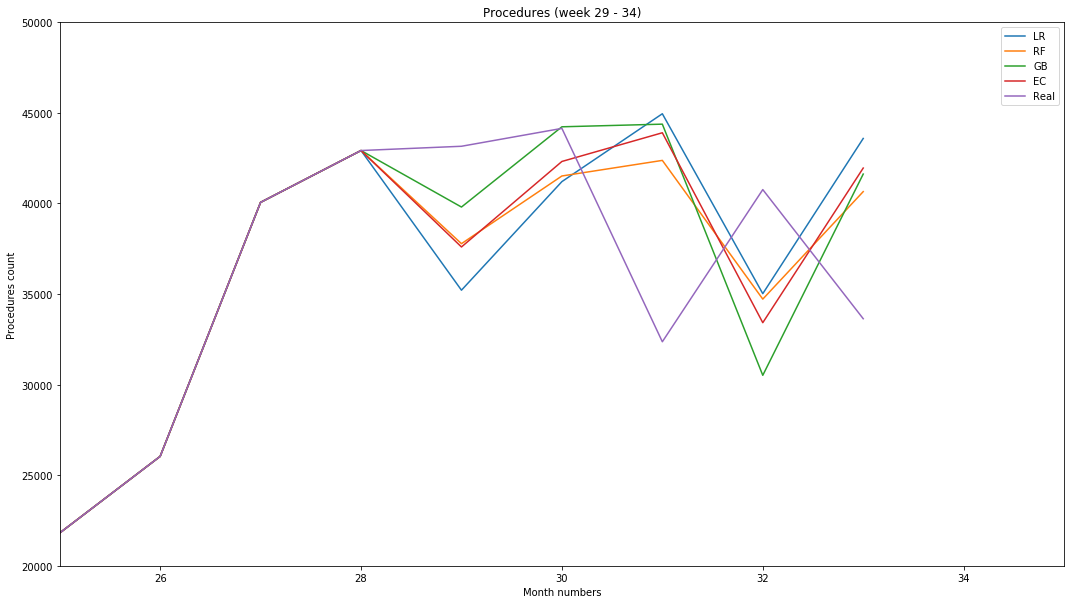

In [78]:
plt.plot(predict_ProcLR4)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcGB4)
plt.plot(predict_ProcEC4)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

In [79]:
%%time
mean_errorRF4_n = []
total_errorRF4_n = []
ProcRF4_n = copy.copy(procedures)
predict_ProcRF4_n = copy.copy(procedures)
abs_pr_errorRF4_n = []
for month in range(month_start, month_end):
    train = melt4[melt4['Month'] < month]
    val = melt4[melt4['Month'] == month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorRF4_n.append(error)
    total_errorRF4_n.append(abs_error)
    ProcRF4_n.append(total_yts)
    predict_ProcRF4_n.append(total_p)
    abs_pr_errorRF4_n.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF4_n))

Month 29 - Error 0.36182, Real Total 43153.0 - Predict Total 32921.6, Abs Error 10231.4, Persent - 23.7
Month 30 - Error 0.33860, Real Total 44140.0 - Predict Total 38365.3, Abs Error 5774.7, Persent - 13.1
Month 31 - Error 0.50818, Real Total 32364.0 - Predict Total 40269.9, Abs Error 7905.9, Persent - 24.4
Month 32 - Error 0.51193, Real Total 40762.0 - Predict Total 32218.7, Abs Error 8543.3, Persent - 21.0
Month 33 - Error 0.41312, Real Total 33636.0 - Predict Total 37838.9, Abs Error 4202.9, Persent - 12.5
Mean Error = 0.42673
Mean Abs Error = 7331.64677
Mean Abs Error persent = 18.93494
Wall time: 36.8 s


In [80]:
%%time
melt12 = melt.copy()
melt12['Last_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift()
melt12['Last_Month_Diff'] = melt12.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt12['Last-1_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-1_Month_Diff'] = melt12.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt12['Last-2_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-2_Month_Diff'] = melt12.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt12['Last-3_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-3_Month_Diff'] = melt12.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt12['Last-4_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-4_Month_Diff'] = melt12.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt12['Last-5_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-5_Month_Diff'] = melt12.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt12['Last-6_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-6_Month_Diff'] = melt12.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt12['Last-7_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-7_Month_Diff'] = melt12.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt12['Last-8_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-8_Month_Diff'] = melt12.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt12['Last-9_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-9_Month_Diff'] = melt12.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt12['Last-10_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-10_Month_Diff'] = melt12.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt12['Last-11_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-11_Month_Diff'] = melt12.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt12['Last-12_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-12_Month_Diff'] = melt12.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt12 = melt12.dropna()
melt12.head()

Wall time: 544 ms


In [81]:
%%time
mean_errorLR12 = []
mean_errorRF12 = []
mean_errorGB12 = []

mean_errorEC12 = []


total_errorLR12 = []
predict_ProcLR12 = copy.copy(procedures)
abs_pr_errorLR12 = []

total_errorRF12 = []
predict_ProcRF12 = copy.copy(procedures)
abs_pr_errorRF12 = []

total_errorGB12 = []
predict_ProcGB12 = copy.copy(procedures)
abs_pr_errorGB12 = []

total_errorEC12 = []
predict_ProcEC12 = copy.copy(procedures)
abs_pr_errorEC12 = []
for Month in range(month_start, month_end):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR12 = rmsle(yts, plr)
    abs_errorLR12 = abs(total_yts-total_plr)
    abs_prLR12 = abs_errorLR12/total_yts*100
    
    mean_errorLR12.append(errorLR12)
    total_errorLR12.append(abs_errorLR12)
    predict_ProcLR12.append(total_plr)
    abs_pr_errorLR12.append(abs_prLR12)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF12 = rmsle(yts, prf)
    abs_errorRF12 = abs(total_yts-total_prf)
    abs_prRF12 = abs_errorRF12/total_yts*100
    
    mean_errorRF12.append(errorRF12)
    total_errorRF12.append(abs_errorRF12)
    predict_ProcRF12.append(total_prf)
    abs_pr_errorRF12.append(abs_prRF12)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB12 = rmsle(yts, pgb)
    abs_errorGB12 = abs(total_yts-total_pgb)
    abs_prGB12 = abs_errorGB12/total_yts*100
    
    mean_errorGB12.append(errorGB12)
    total_errorGB12.append(abs_errorGB12)
    predict_ProcGB12.append(total_pgb)
    abs_pr_errorGB12.append(abs_prGB12)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC12=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC12)

    errorEC12 = rmsle(yts, pEC12)
    abs_errorEC12 = abs(total_yts-total_pec)
    abs_prEC12 = abs_errorEC12/total_yts*100
    
    mean_errorEC12.append(errorEC12)
    total_errorEC12.append(abs_errorEC12)
    predict_ProcEC12.append(total_pec)
    abs_pr_errorEC12.append(abs_prEC12)
    print('Month %d' % (Month))
    print('LR12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR12, total_yts, total_plr, abs_errorLR12, abs_prLR12))
    print('RF12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF12, total_yts, total_prf, abs_errorRF12, abs_prRF12))
    print('GB12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB12, total_yts, total_pgb, abs_errorGB12, abs_prGB12))
    print('EC12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC12, total_yts, total_pec, abs_errorEC12, abs_prEC12))
print('Mean Error')
print('LR12 = %.5f, RF12 = %.5f, GB12 = %.5f, EC12 = %.5f' % (np.mean(mean_errorLR12), np.mean(mean_errorRF12), np.mean(mean_errorGB12), np.mean(mean_errorEC12)))
print('Mean Abs Error')
print('LR12 = %.1f, RF12 = %.1f, GB12 = %.1f, EC12 = %.1f' % (np.mean(total_errorLR12), np.mean(total_errorRF12), np.mean(total_errorGB12), np.mean(total_errorEC12)))
print('Mean Abs Error persent')
print('LR12 = %.1f, RF12 = %.1f, GB12 = %.1f, EC12 = %.1f' % (np.mean(abs_pr_errorLR12), np.mean(abs_pr_errorRF12), np.mean(abs_pr_errorGB12), np.mean(abs_pr_errorEC12)))

Month 29
LR12 - Error 0.61286, Real Total 43153.0 - Predict Total 35210.5, Abs Error 7942.5, Persent - 18.4
RF12 - Error 0.33750, Real Total 43153.0 - Predict Total 37657.2, Abs Error 5495.8, Persent - 12.7
GB12 - Error 0.34730, Real Total 43153.0 - Predict Total 39798.9, Abs Error 3354.1, Persent - 7.8
EC12 - Error 0.44102, Real Total 43153.0 - Predict Total 37555.5, Abs Error 5597.5, Persent - 13.0
Month 30
LR12 - Error 0.68276, Real Total 44140.0 - Predict Total 41238.2, Abs Error 2901.8, Persent - 6.6
RF12 - Error 0.30362, Real Total 44140.0 - Predict Total 41457.9, Abs Error 2682.1, Persent - 6.1
GB12 - Error 0.33160, Real Total 44140.0 - Predict Total 44227.6, Abs Error 87.6, Persent - 0.2
EC12 - Error 0.49590, Real Total 44140.0 - Predict Total 42307.9, Abs Error 1832.1, Persent - 4.2
Month 31
LR12 - Error 0.94615, Real Total 32364.0 - Predict Total 44901.8, Abs Error 12537.8, Persent - 38.7
RF12 - Error 0.60140, Real Total 32364.0 - Predict Total 42242.3, Abs Error 9878.3, Pers

(20000, 50000)

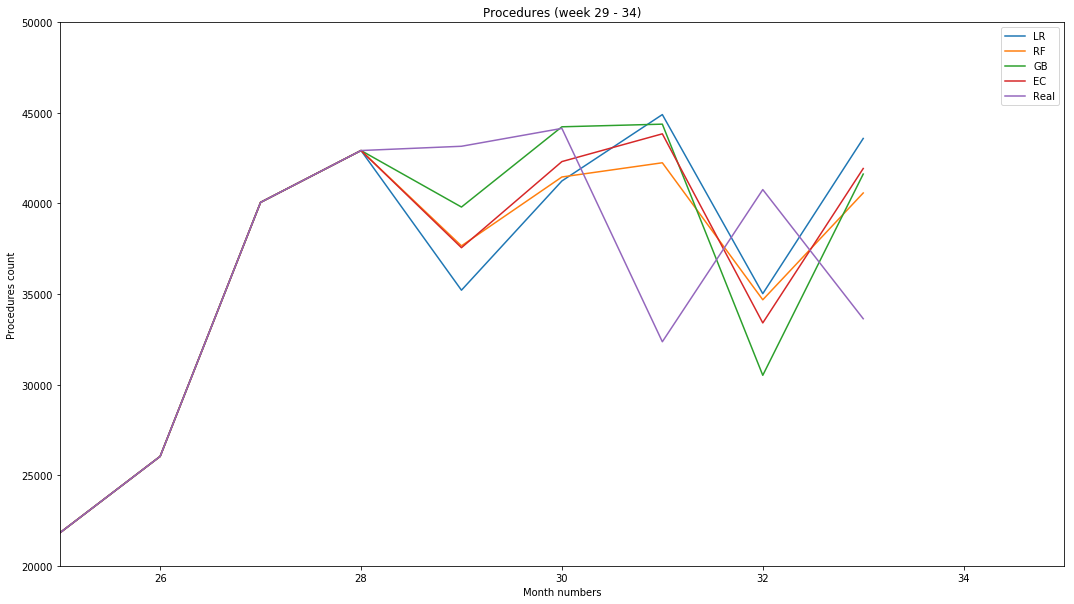

In [82]:
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcEC12)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



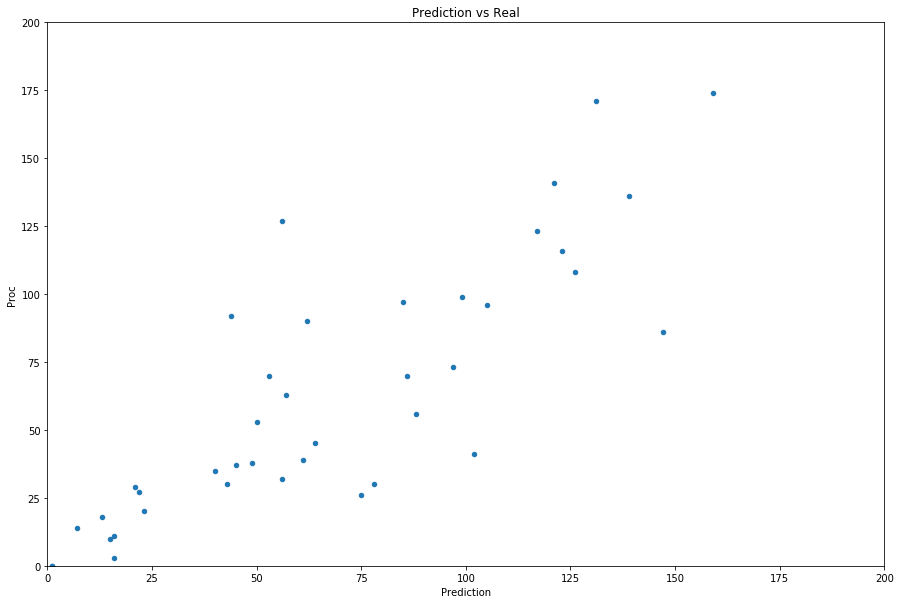

In [83]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,200), xlim=(0,200))

In [84]:
%%time
melt24 = melt.copy()
melt24['Last_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift()
melt24['Last_Month_Diff'] = melt24.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt24['Last-1_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-1_Month_Diff'] = melt24.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt24['Last-2_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-2_Month_Diff'] = melt24.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt24['Last-3_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-3_Month_Diff'] = melt24.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt24['Last-4_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-4_Month_Diff'] = melt24.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt24['Last-5_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-5_Month_Diff'] = melt24.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt24['Last-6_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-6_Month_Diff'] = melt24.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt24['Last-7_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-7_Month_Diff'] = melt24.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt24['Last-8_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-8_Month_Diff'] = melt24.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt24['Last-9_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-9_Month_Diff'] = melt24.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt24['Last-10_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-10_Month_Diff'] = melt24.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt24['Last-11_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-11_Month_Diff'] = melt24.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt24['Last-12_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-12_Month_Diff'] = melt24.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt24['Last-13_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-13_Month_Diff'] = melt24.groupby(['RegCode'])['Last-13_Month_Proc'].diff()
melt24['Last-14_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-14_Month_Diff'] = melt24.groupby(['RegCode'])['Last-14_Month_Proc'].diff()
melt24['Last-15_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-15_Month_Diff'] = melt24.groupby(['RegCode'])['Last-15_Month_Proc'].diff()
melt24['Last-16_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-16_Month_Diff'] = melt24.groupby(['RegCode'])['Last-16_Month_Proc'].diff()
melt24['Last-17_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-17_Month_Diff'] = melt24.groupby(['RegCode'])['Last-17_Month_Proc'].diff()
melt24['Last-18_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-18_Month_Diff'] = melt24.groupby(['RegCode'])['Last-18_Month_Proc'].diff()
melt24['Last-19_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-19_Month_Diff'] = melt24.groupby(['RegCode'])['Last-19_Month_Proc'].diff()
melt24['Last-20_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-20_Month_Diff'] = melt24.groupby(['RegCode'])['Last-20_Month_Proc'].diff()
melt24['Last-21_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-21_Month_Diff'] = melt24.groupby(['RegCode'])['Last-21_Month_Proc'].diff()
melt24['Last-22_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-22_Month_Diff'] = melt24.groupby(['RegCode'])['Last-22_Month_Proc'].diff()
melt24['Last-23_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-23_Month_Diff'] = melt24.groupby(['RegCode'])['Last-23_Month_Proc'].diff()
melt24['Last-24_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-24_Month_Diff'] = melt24.groupby(['RegCode'])['Last-24_Month_Proc'].diff()
melt24 = melt24.dropna()
melt24.head()

Wall time: 720 ms


In [85]:
%%time
mean_errorLR24 = []
mean_errorRF24 = []
mean_errorGB24 = []

mean_errorEC24 = []


total_errorLR24 = []
predict_ProcLR24 = copy.copy(procedures)
abs_pr_errorLR24 = []

total_errorRF24 = []
predict_ProcRF24 = copy.copy(procedures)
abs_pr_errorRF24 = []

total_errorGB24 = []
predict_ProcGB24 = copy.copy(procedures)
abs_pr_errorGB24 = []

total_errorEC24 = []
predict_ProcEC24 = copy.copy(procedures)
abs_pr_errorEC24 = []
for Month in range(month_start, month_end):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR24 = rmsle(yts, plr)
    abs_errorLR24 = abs(total_yts-total_plr)
    abs_prLR24 = abs_errorLR24/total_yts*100
    
    mean_errorLR24.append(errorLR24)
    total_errorLR24.append(abs_errorLR24)
    predict_ProcLR24.append(total_plr)
    abs_pr_errorLR24.append(abs_prLR24)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF24 = rmsle(yts, prf)
    abs_errorRF24 = abs(total_yts-total_prf)
    abs_prRF24 = abs_errorRF24/total_yts*100
    
    mean_errorRF24.append(errorRF24)
    total_errorRF24.append(abs_errorRF24)
    predict_ProcRF24.append(total_prf)
    abs_pr_errorRF24.append(abs_prRF24)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB24 = rmsle(yts, pgb)
    abs_errorGB24 = abs(total_yts-total_pgb)
    abs_prGB24 = abs_errorGB24/total_yts*100
    
    mean_errorGB24.append(errorGB24)
    total_errorGB24.append(abs_errorGB24)
    predict_ProcGB24.append(total_pgb)
    abs_pr_errorGB24.append(abs_prGB24)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC24=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC24)

    errorEC24 = rmsle(yts, pEC24)
    abs_errorEC24 = abs(total_yts-total_pec)
    abs_prEC24 = abs_errorEC24/total_yts*100
    
    mean_errorEC24.append(errorEC24)
    total_errorEC24.append(abs_errorEC24)
    predict_ProcEC24.append(total_pec)
    abs_pr_errorEC24.append(abs_prEC24)
    print('Month %d' % (Month))
    print('LR24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR24, total_yts, total_plr, abs_errorLR24, abs_prLR24))
    print('RF24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF24, total_yts, total_prf, abs_errorRF24, abs_prRF24))
    print('GB24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB24, total_yts, total_pgb, abs_errorGB24, abs_prGB24))
    print('EC24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC24, total_yts, total_pec, abs_errorEC24, abs_prEC24))
print('Mean Error')
print('LR24 = %.5f, RF24 = %.5f, GB24 = %.5f, EC24 = %.5f' % (np.mean(mean_errorLR24), np.mean(mean_errorRF24), np.mean(mean_errorGB24), np.mean(mean_errorEC24)))
print('Mean Abs Error')
print('LR24 = %.1f, RF24 = %.1f, GB24 = %.1f, EC24 = %.1f' % (np.mean(total_errorLR24), np.mean(total_errorRF24), np.mean(total_errorGB24), np.mean(total_errorEC24)))
print('Mean Abs Error persent')
print('LR24 = %.1f, RF24 = %.1f, GB24 = %.1f, EC24 = %.1f' % (np.mean(abs_pr_errorLR24), np.mean(abs_pr_errorRF24), np.mean(abs_pr_errorGB24), np.mean(abs_pr_errorEC24)))

Month 29
LR24 - Error 0.61286, Real Total 43153.0 - Predict Total 35210.5, Abs Error 7942.5, Persent - 18.4
RF24 - Error 0.33773, Real Total 43153.0 - Predict Total 37590.7, Abs Error 5562.3, Persent - 12.9
GB24 - Error 0.34730, Real Total 43153.0 - Predict Total 39798.9, Abs Error 3354.1, Persent - 7.8
EC24 - Error 0.44110, Real Total 43153.0 - Predict Total 37533.4, Abs Error 5619.6, Persent - 13.0
Month 30
LR24 - Error 0.66803, Real Total 44140.0 - Predict Total 40917.1, Abs Error 3222.9, Persent - 7.3
RF24 - Error 0.30472, Real Total 44140.0 - Predict Total 41495.9, Abs Error 2644.1, Persent - 6.0
GB24 - Error 0.33160, Real Total 44140.0 - Predict Total 44227.6, Abs Error 87.6, Persent - 0.2
EC24 - Error 0.48627, Real Total 44140.0 - Predict Total 42213.5, Abs Error 1926.5, Persent - 4.4
Month 31
LR24 - Error 0.94958, Real Total 32364.0 - Predict Total 44792.5, Abs Error 12428.5, Persent - 38.4
RF24 - Error 0.60105, Real Total 32364.0 - Predict Total 42304.4, Abs Error 9940.4, Pers

(20000, 50000)

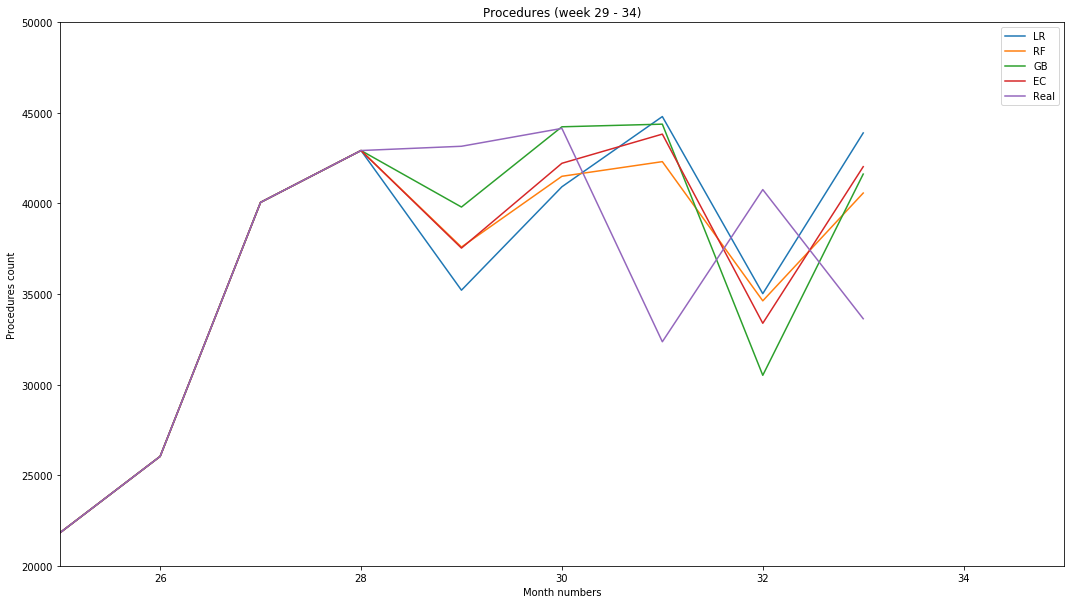

In [86]:
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(predict_ProcEC24)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

(20000, 60000)

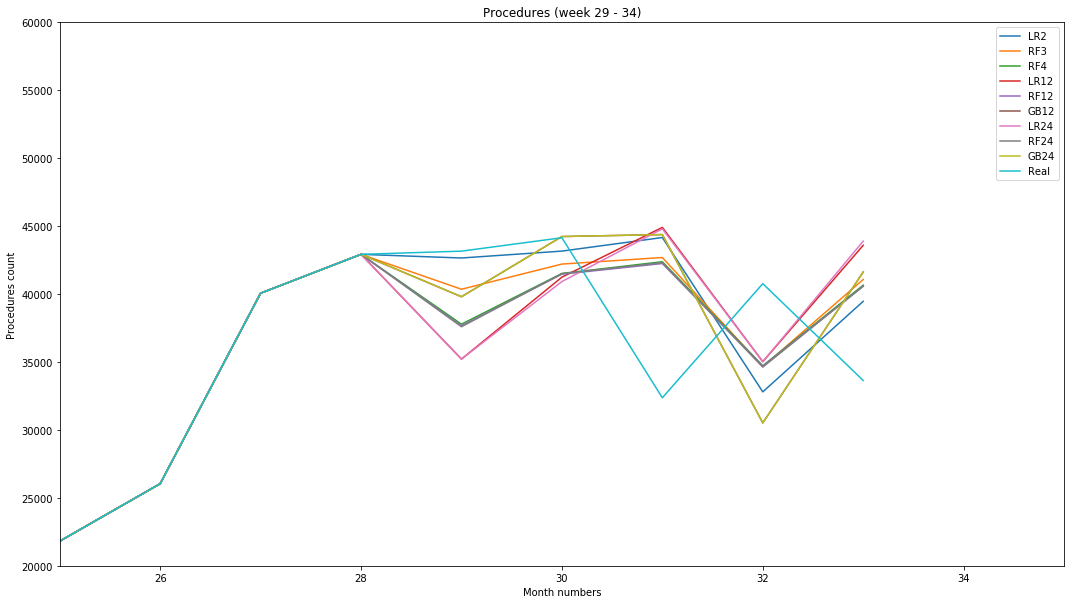

In [87]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(proceduresAll)

plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR2', 'RF3', 'RF4', 'LR12', 'RF12', 'GB12', 'LR24', 'RF24', 'GB24', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 60000)

In [88]:
print('Mean Error baseline = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error baseline = %.5f' % np.mean(total_errorB))
print('Mean Abs Error baseline persent = %.5f' % np.mean(abs_pr_errorB))
print('Mean Error LR2 = %.5f' % np.mean(mean_errorLR2))
print('Mean Abs Error LR2 = %.5f' % np.mean(total_errorLR2))
print('Mean Abs Error LR2 persent = %.5f' % np.mean(abs_pr_errorLR2))
print('Mean Error RF2 = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error RF2 = %.5f' % np.mean(total_errorRF2))
print('Mean Abs Error RF2 persent = %.5f' % np.mean(abs_pr_errorRF2))
print('Mean Error RF3 = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error RF3 = %.5f' % np.mean(total_errorRF3))
print('Mean Abs Error RF3 persent = %.5f' % np.mean(abs_pr_errorRF3))
print('Mean Error RF4 = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error RF4 = %.5f' % np.mean(total_errorRF4))
print('Mean Abs Error RF4 persent = %.5f' % np.mean(abs_pr_errorRF4))
print('Mean Error RF4_n = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error RF4_n = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error RF4_n persent = %.5f' % np.mean(abs_pr_errorRF4_n))
print('Mean Error GB4 = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error GB4 = %.5f' % np.mean(total_errorGB4))
print('Mean Abs Error GB4 persent = %.5f' % np.mean(abs_pr_errorGB4))
print('Mean Error LR12 = %.5f' % np.mean(mean_errorLR12))
print('Mean Abs Error LR12 = %.5f' % np.mean(total_errorLR12))
print('Mean Abs Error LR12 persent = %.5f' % np.mean(abs_pr_errorLR12))
print('Mean Error = %.5f' % np.mean(mean_errorRF12))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF12))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF12))
print('Mean Error GB12 = %.5f' % np.mean(mean_errorGB12))
print('Mean Abs Error GB12 = %.5f' % np.mean(total_errorGB12))
print('Mean Abs Error GB12 persent = %.5f' % np.mean(abs_pr_errorGB12))
print('Mean Error LR24 = %.5f' % np.mean(mean_errorLR24))
print('Mean Abs Error LR24 = %.5f' % np.mean(total_errorLR24))
print('Mean Abs Error LR24 persent = %.5f' % np.mean(abs_pr_errorLR24))
print('Mean Error = %.5f' % np.mean(mean_errorRF24))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF24))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF24))
print('Mean Error GB24 = %.5f' % np.mean(mean_errorGB24))
print('Mean Abs Error GB24 = %.5f' % np.mean(total_errorGB24))
print('Mean Abs Error GB24 persent = %.5f' % np.mean(abs_pr_errorGB24))

Mean Error baseline = 0.42341
Mean Abs Error baseline = 5704.40000
Mean Abs Error baseline persent = 16.19098
Mean Error LR2 = 0.80785
Mean Abs Error LR2 = 5413.35870
Mean Abs Error LR2 persent = 15.33654
Mean Error RF2 = 0.45358
Mean Abs Error RF2 = 4790.48780
Mean Abs Error RF2 persent = 13.78424
Mean Error RF3 = 0.45441
Mean Abs Error RF3 = 5720.34560
Mean Abs Error RF3 persent = 15.97110
Mean Error RF4 = 0.45096
Mean Abs Error RF4 = 6213.92220
Mean Abs Error RF4 persent = 17.00308
Mean Error RF4_n = 0.42673
Mean Abs Error RF4_n = 7331.64677
Mean Abs Error RF4_n persent = 18.93494
Mean Error GB4 = 0.45815
Mean Abs Error GB4 = 6736.66834
Mean Abs Error GB4 persent = 18.79119
Mean Error LR12 = 0.72143
Mean Abs Error LR12 = 7814.65068
Mean Abs Error LR12 persent = 21.47689
Mean Error = 0.45207
Mean Abs Error = 6215.20280
Mean Abs Error persent = 16.97641
Mean Error GB12 = 0.45815
Mean Abs Error GB12 = 6736.66834
Mean Abs Error GB12 persent = 18.79119
Mean Error LR24 = 0.72652
Mean Abs 

In [89]:
cols = ['RegCode', 'Month', 'Last_Month_Proc', 'Last_Month_Diff',
       'Last-1_Month_Proc', 'Last-1_Month_Diff', 'Last-2_Month_Proc',
       'Last-2_Month_Diff', 'Last-3_Month_Proc', 'Last-3_Month_Diff',
       'Last-4_Month_Proc', 'Last-4_Month_Diff', 'Last-5_Month_Proc',
       'Last-5_Month_Diff', 'Last-6_Month_Proc', 'Last-6_Month_Diff',
       'Last-7_Month_Proc', 'Last-7_Month_Diff', 'Last-8_Month_Proc',
       'Last-8_Month_Diff', 'Last-9_Month_Proc', 'Last-9_Month_Diff',
       'Last-10_Month_Proc', 'Last-10_Month_Diff', 'Last-11_Month_Proc',
       'Last-11_Month_Diff', 'Last-12_Month_Proc', 'Last-12_Month_Diff',
       'Last-13_Month_Proc', 'Last-13_Month_Diff', 'Last-14_Month_Proc',
       'Last-14_Month_Diff', 'Last-15_Month_Proc', 'Last-15_Month_Diff',
       'Last-16_Month_Proc', 'Last-16_Month_Diff', 'Last-17_Month_Proc',
       'Last-17_Month_Diff', 'Last-18_Month_Proc', 'Last-18_Month_Diff',
       'Last-19_Month_Proc', 'Last-19_Month_Diff', 'Last-20_Month_Proc',
       'Last-20_Month_Diff', 'Last-21_Month_Proc', 'Last-21_Month_Diff',
       'Last-22_Month_Proc', 'Last-22_Month_Diff', 'Last-23_Month_Proc',
       'Last-23_Month_Diff', 'Last-24_Month_Proc', 'Last-24_Month_Diff']

In [90]:
%%time
#Заготовка под массив столбцов
c = []
colMeanError =[]
#Переменная под максимальное значение score
minErrorValue=100
colMeanAbsError =[]
bestPredictPorc_er = []
minAbsErrorValue=100
minAbsError=250000000000
bestPredictPorc_AbsEr = []
  
#Запоминаем длинну выборки столбцов - 1 (последний столбец - целевая переменная)
l=len(cols) - 1
#В трех циклах последовательно проходим по столбцам и формируем тройки, для каждой трокий делаем get_dummies для 
#перечислимых переменных, строим модель и вычисляем score.
#В переменных maxValue и bestParams сохраняем значения лучщего score и набор параметров, для которого он получился
bestCols = []
for i in range(0, l, 1):
    for j in range(i+1, l, 1):
        #Проверяем, что у нас нет одинаковых столбцов в выборке
        if cols[i]==cols[j]:
            continue
        c = []
        #Добавляем названия столбцов в выборку    
        c.append(cols[i])
        c.append(cols[j])
        mean_error = []
        total_error = []
        Proc = copy.copy(procedures)
        predict_Proc = copy.copy(procedures)
        abs_pr_error = []
        for Month in range(month_start, month_end):
            train = melt24[melt24['Month'] < Month]
            val = melt24[melt24['Month'] == Month]
            
            #Выделяем столбцы для эксперимента
            xtr, xts = train[c].values, val[c].values
            ytr, yts = train['Proc'].values, val['Proc'].values
                
            mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
            mdl.fit(xtr, ytr)
    
            p = mdl.predict(xts)
    
            total_yts=sum(yts)
            total_p=sum(p)
                
            error = rmsle(yts, p)
            abs_error = abs(total_yts-total_p)
            abs_pr = abs_error/total_yts*100

            #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
            mean_error.append(error)
            total_error.append(abs_error)
            Proc.append(total_yts)
            predict_Proc.append(total_p)
            abs_pr_error.append(abs_pr)
        MR = np.mean(mean_error)
        TR = np.mean(total_error)
        TRP = np.mean(abs_pr_error)
        print(c)
        print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
        if MR<minErrorValue:
            minErrorValue=MR
            colMeanError=c
            bestPredictPorc_er = predict_Proc
        if TRP<minAbsErrorValue:
            minAbsErrorValue=TRP
            colMeanAbsError=c
            bestPredictPorc_AbsEr = predict_Proc
        if TR<minAbsError:
            minAbsError=TR
            bestCols=c
            bestPredictPorc_AbsEr = predict_Proc
                

['RegCode', 'Month']
Mean Error 0.45030, Abs Error 5081.0, Abs Error Persent - 14.3
['RegCode', 'Last_Month_Proc']
Mean Error 0.49780, Abs Error 5152.1, Abs Error Persent - 14.4
['RegCode', 'Last_Month_Diff']
Mean Error 0.79626, Abs Error 5933.4, Abs Error Persent - 14.7
['RegCode', 'Last-1_Month_Proc']
Mean Error 0.50123, Abs Error 5878.7, Abs Error Persent - 15.4
['RegCode', 'Last-1_Month_Diff']
Mean Error 0.78838, Abs Error 5408.6, Abs Error Persent - 13.7
['RegCode', 'Last-2_Month_Proc']
Mean Error 0.58830, Abs Error 6005.1, Abs Error Persent - 15.4
['RegCode', 'Last-2_Month_Diff']
Mean Error 0.81160, Abs Error 5756.5, Abs Error Persent - 13.7
['RegCode', 'Last-3_Month_Proc']
Mean Error 0.58830, Abs Error 6005.1, Abs Error Persent - 15.4
['RegCode', 'Last-3_Month_Diff']
Mean Error 0.81160, Abs Error 5756.5, Abs Error Persent - 13.7
['RegCode', 'Last-4_Month_Proc']
Mean Error 0.58830, Abs Error 6005.1, Abs Error Persent - 15.4
['RegCode', 'Last-4_Month_Diff']
Mean Error 0.81160, Abs

['Month', 'Last-18_Month_Proc']
Mean Error 0.72104, Abs Error 9770.8, Abs Error Persent - 26.0
['Month', 'Last-18_Month_Diff']
Mean Error 1.36471, Abs Error 7349.8, Abs Error Persent - 18.2
['Month', 'Last-19_Month_Proc']
Mean Error 0.72104, Abs Error 9770.8, Abs Error Persent - 26.0
['Month', 'Last-19_Month_Diff']
Mean Error 1.36471, Abs Error 7349.8, Abs Error Persent - 18.2
['Month', 'Last-20_Month_Proc']
Mean Error 0.72104, Abs Error 9770.8, Abs Error Persent - 26.0
['Month', 'Last-20_Month_Diff']
Mean Error 1.36471, Abs Error 7349.8, Abs Error Persent - 18.2
['Month', 'Last-21_Month_Proc']
Mean Error 0.58213, Abs Error 7552.1, Abs Error Persent - 20.2
['Month', 'Last-21_Month_Diff']
Mean Error 1.32247, Abs Error 14414.5, Abs Error Persent - 39.4
['Month', 'Last-22_Month_Proc']
Mean Error 0.72104, Abs Error 9770.8, Abs Error Persent - 26.0
['Month', 'Last-22_Month_Diff']
Mean Error 1.36471, Abs Error 7349.8, Abs Error Persent - 18.2
['Month', 'Last-23_Month_Proc']
Mean Error 0.7210

['Last_Month_Diff', 'Last-10_Month_Diff']
Mean Error 0.92060, Abs Error 6210.4, Abs Error Persent - 15.8
['Last_Month_Diff', 'Last-11_Month_Proc']
Mean Error 0.50295, Abs Error 5171.0, Abs Error Persent - 14.3
['Last_Month_Diff', 'Last-11_Month_Diff']
Mean Error 0.88540, Abs Error 8223.9, Abs Error Persent - 21.4
['Last_Month_Diff', 'Last-12_Month_Proc']
Mean Error 0.63001, Abs Error 8648.3, Abs Error Persent - 23.1
['Last_Month_Diff', 'Last-12_Month_Diff']
Mean Error 0.92060, Abs Error 6210.4, Abs Error Persent - 15.8
['Last_Month_Diff', 'Last-13_Month_Proc']
Mean Error 0.63001, Abs Error 8648.3, Abs Error Persent - 23.1
['Last_Month_Diff', 'Last-13_Month_Diff']
Mean Error 0.92060, Abs Error 6210.4, Abs Error Persent - 15.8
['Last_Month_Diff', 'Last-14_Month_Proc']
Mean Error 0.63001, Abs Error 8648.3, Abs Error Persent - 23.1
['Last_Month_Diff', 'Last-14_Month_Diff']
Mean Error 0.92060, Abs Error 6210.4, Abs Error Persent - 15.8
['Last_Month_Diff', 'Last-15_Month_Proc']
Mean Error 0.

['Last-1_Month_Diff', 'Last-4_Month_Proc']
Mean Error 0.57972, Abs Error 5391.5, Abs Error Persent - 14.4
['Last-1_Month_Diff', 'Last-4_Month_Diff']
Mean Error 0.89775, Abs Error 6898.2, Abs Error Persent - 17.8
['Last-1_Month_Diff', 'Last-5_Month_Proc']
Mean Error 0.57972, Abs Error 5391.5, Abs Error Persent - 14.4
['Last-1_Month_Diff', 'Last-5_Month_Diff']
Mean Error 0.89775, Abs Error 6898.2, Abs Error Persent - 17.8
['Last-1_Month_Diff', 'Last-6_Month_Proc']
Mean Error 0.57972, Abs Error 5391.5, Abs Error Persent - 14.4
['Last-1_Month_Diff', 'Last-6_Month_Diff']
Mean Error 0.89775, Abs Error 6898.2, Abs Error Persent - 17.8
['Last-1_Month_Diff', 'Last-7_Month_Proc']
Mean Error 0.57972, Abs Error 5391.5, Abs Error Persent - 14.4
['Last-1_Month_Diff', 'Last-7_Month_Diff']
Mean Error 0.89775, Abs Error 6898.2, Abs Error Persent - 17.8
['Last-1_Month_Diff', 'Last-8_Month_Proc']
Mean Error 0.57972, Abs Error 5391.5, Abs Error Persent - 14.4
['Last-1_Month_Diff', 'Last-8_Month_Diff']
Mea

['Last-2_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-2_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.57815, Abs Error 5742.8, Abs Error Persent - 15.3
['Last-2_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.57971, Abs Error 5396.3, Abs Error Persent - 14.4
['Last-2_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-2_Month_Proc', 'Last-22_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-2_Month_Proc', 'Last-23_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-2_Month_Proc', 'Last-23_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-2_Month_Proc', 'Last-24_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-2_Month_Diff', 'Last-3_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-2_Month_Diff', 'Last-3_Month_Di

['Last-3_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-3_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-3_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-3_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-3_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-3_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-3_Month_Proc', 'Last-19_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-3_Month_Proc', 'Last-20_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-3_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-3_Month_Proc', 'Last-21_Month_

['Last-4_Month_Proc', 'Last-14_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-4_Month_Proc', 'Last-15_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-4_Month_Proc', 'Last-15_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-4_Month_Proc', 'Last-16_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-4_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-4_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-4_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-4_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-4_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-4_Month_Proc', 'Last-19_Month_

['Last-5_Month_Proc', 'Last-14_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-5_Month_Proc', 'Last-15_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-5_Month_Proc', 'Last-15_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-5_Month_Proc', 'Last-16_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-5_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-5_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-5_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-5_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-5_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-5_Month_Proc', 'Last-19_Month_

['Last-6_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-6_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-6_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-6_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-6_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-6_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-6_Month_Proc', 'Last-19_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-6_Month_Proc', 'Last-20_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-6_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-6_Month_Proc', 'Last-21_Month_

['Last-7_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-7_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.57815, Abs Error 5742.8, Abs Error Persent - 15.3
['Last-7_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.57971, Abs Error 5396.3, Abs Error Persent - 14.4
['Last-7_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-7_Month_Proc', 'Last-22_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-7_Month_Proc', 'Last-23_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-7_Month_Proc', 'Last-23_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-7_Month_Proc', 'Last-24_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-7_Month_Diff', 'Last-8_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-7_Month_Diff', 'Last-8_Month_Di

['Last-8_Month_Diff', 'Last-11_Month_Proc']
Mean Error 0.54635, Abs Error 3928.3, Abs Error Persent - 10.4
['Last-8_Month_Diff', 'Last-11_Month_Diff']
Mean Error 0.89776, Abs Error 6888.8, Abs Error Persent - 17.8
['Last-8_Month_Diff', 'Last-12_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-8_Month_Diff', 'Last-12_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-8_Month_Diff', 'Last-13_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-8_Month_Diff', 'Last-13_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-8_Month_Diff', 'Last-14_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-8_Month_Diff', 'Last-14_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-8_Month_Diff', 'Last-15_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-8_Month_Diff', 'Last-15_Month_

['Last-9_Month_Diff', 'Last-20_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-9_Month_Diff', 'Last-20_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-9_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.54635, Abs Error 3928.3, Abs Error Persent - 10.4
['Last-9_Month_Diff', 'Last-21_Month_Diff']
Mean Error 0.89776, Abs Error 6888.8, Abs Error Persent - 17.8
['Last-9_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-9_Month_Diff', 'Last-22_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-9_Month_Diff', 'Last-23_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-9_Month_Diff', 'Last-23_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-9_Month_Diff', 'Last-24_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-10_Month_Proc', 'Last-10_Month

['Last-11_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.54605, Abs Error 3930.5, Abs Error Persent - 10.4
['Last-11_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.57815, Abs Error 5742.8, Abs Error Persent - 15.3
['Last-11_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.54605, Abs Error 3930.5, Abs Error Persent - 10.4
['Last-11_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.57815, Abs Error 5742.8, Abs Error Persent - 15.3
['Last-11_Month_Proc', 'Last-19_Month_Diff']
Mean Error 0.54605, Abs Error 3930.5, Abs Error Persent - 10.4
['Last-11_Month_Proc', 'Last-20_Month_Proc']
Mean Error 0.57815, Abs Error 5742.8, Abs Error Persent - 15.3
['Last-11_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.54605, Abs Error 3930.5, Abs Error Persent - 10.4
['Last-11_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.65775, Abs Error 3353.7, Abs Error Persent - 9.6
['Last-11_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.56767, Abs Error 5721.7, Abs Error Persent - 15.2
['Last-11_Month_Proc', 'Last-

['Last-12_Month_Diff', 'Last-19_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-12_Month_Diff', 'Last-20_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-12_Month_Diff', 'Last-20_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-12_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.54635, Abs Error 3928.3, Abs Error Persent - 10.4
['Last-12_Month_Diff', 'Last-21_Month_Diff']
Mean Error 0.89776, Abs Error 6888.8, Abs Error Persent - 17.8
['Last-12_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-12_Month_Diff', 'Last-22_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-12_Month_Diff', 'Last-23_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-12_Month_Diff', 'Last-23_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-12_Month_Diff', 'Last

['Last-14_Month_Diff', 'Last-16_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-14_Month_Diff', 'Last-17_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-14_Month_Diff', 'Last-17_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-14_Month_Diff', 'Last-18_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-14_Month_Diff', 'Last-18_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-14_Month_Diff', 'Last-19_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-14_Month_Diff', 'Last-19_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-14_Month_Diff', 'Last-20_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-14_Month_Diff', 'Last-20_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-14_Month_Diff', 'Last

['Last-16_Month_Diff', 'Last-21_Month_Diff']
Mean Error 0.89776, Abs Error 6888.8, Abs Error Persent - 17.8
['Last-16_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-16_Month_Diff', 'Last-22_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-16_Month_Diff', 'Last-23_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-16_Month_Diff', 'Last-23_Month_Diff']
Mean Error 1.29004, Abs Error 8122.1, Abs Error Persent - 20.6
['Last-16_Month_Diff', 'Last-24_Month_Proc']
Mean Error 0.62819, Abs Error 7457.5, Abs Error Persent - 18.9
['Last-17_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-17_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-17_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-17_Month_Proc', 'Last

['Last-20_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.57815, Abs Error 5742.8, Abs Error Persent - 15.3
['Last-20_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.57971, Abs Error 5396.3, Abs Error Persent - 14.4
['Last-20_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-20_Month_Proc', 'Last-22_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-20_Month_Proc', 'Last-23_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-20_Month_Proc', 'Last-23_Month_Diff']
Mean Error 0.62814, Abs Error 7474.1, Abs Error Persent - 18.9
['Last-20_Month_Proc', 'Last-24_Month_Proc']
Mean Error 0.77878, Abs Error 8755.0, Abs Error Persent - 23.5
['Last-20_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.54635, Abs Error 3928.3, Abs Error Persent - 10.4
['Last-20_Month_Diff', 'Last-21_Month_Diff']
Mean Error 0.89776, Abs Error 6888.8, Abs Error Persent - 17.8
['Last-20_Month_Diff', 'Last

In [91]:
print (minErrorValue)
print(colMeanError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.4502991243778012
['RegCode', 'Month']
9.613871538153251
['Last-1_Month_Proc', 'Last-11_Month_Proc']
3353.712184099073
['Last-1_Month_Proc', 'Last-11_Month_Proc']


In [92]:
k = copy.copy(bestCols)
print(bestCols)

['Last-1_Month_Proc', 'Last-11_Month_Proc']


In [93]:
%%time
k = copy.copy(colMeanError)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = Proc

['RegCode', 'Month', 'Last_Month_Proc']
Mean Error 0.49638, Abs Error 6069.6, Abs Error Persent - 17.3
['RegCode', 'Month', 'Last_Month_Diff']
Mean Error 1.09067, Abs Error 10258.1, Abs Error Persent - 26.8
['RegCode', 'Month', 'Last-1_Month_Proc']
Mean Error 0.52253, Abs Error 5038.1, Abs Error Persent - 14.0
['RegCode', 'Month', 'Last-1_Month_Diff']
Mean Error 1.11543, Abs Error 9922.8, Abs Error Persent - 27.5
['RegCode', 'Month', 'Last-2_Month_Proc']
Mean Error 0.61399, Abs Error 7094.5, Abs Error Persent - 19.9
['RegCode', 'Month', 'Last-2_Month_Diff']
Mean Error 1.10649, Abs Error 6004.7, Abs Error Persent - 15.5
['RegCode', 'Month', 'Last-3_Month_Proc']
Mean Error 0.61399, Abs Error 7094.5, Abs Error Persent - 19.9
['RegCode', 'Month', 'Last-3_Month_Diff']
Mean Error 1.10649, Abs Error 6004.7, Abs Error Persent - 15.5
['RegCode', 'Month', 'Last-4_Month_Proc']
Mean Error 0.61399, Abs Error 7094.5, Abs Error Persent - 19.9
['RegCode', 'Month', 'Last-4_Month_Diff']
Mean Error 1.106

In [94]:
print (minErrorValue)
print(colMeanError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.4502991243778012
['RegCode', 'Month']
9.613871538153251
['Last-1_Month_Proc', 'Last-11_Month_Proc']
3353.712184099073
['Last-1_Month_Proc', 'Last-11_Month_Proc']


In [95]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = predict_Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = predict_Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = predict_Proc

['Last-1_Month_Proc', 'Last-11_Month_Proc', 'RegCode']
Mean Error 0.50322, Abs Error 5937.5, Abs Error Persent - 15.6
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Month']
Mean Error 0.58305, Abs Error 7484.3, Abs Error Persent - 20.0
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last_Month_Proc']
Mean Error 0.47894, Abs Error 5200.5, Abs Error Persent - 14.1
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last_Month_Diff']
Mean Error 0.50328, Abs Error 5158.4, Abs Error Persent - 14.3
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-1_Month_Diff']
Mean Error 0.56893, Abs Error 5819.0, Abs Error Persent - 15.5
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-2_Month_Proc']
Mean Error 0.57665, Abs Error 5768.4, Abs Error Persent - 15.3
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-2_Month_Diff']
Mean Error 0.54593, Abs Error 3952.1, Abs Error Persent - 10.4
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-3_Month_Proc']
Mean Error 0.57665, Abs Error 5768.4, Abs Error Persent - 15.3
['

In [96]:
print (minErrorValue)
print(colMeanError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.4502991243778012
['RegCode', 'Month']
9.613871538153251
['Last-1_Month_Proc', 'Last-11_Month_Proc']
3353.712184099073
['Last-1_Month_Proc', 'Last-11_Month_Proc']


In [97]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = predict_Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = predict_Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = predict_Proc

['Last-1_Month_Proc', 'Last-11_Month_Proc', 'RegCode']
Mean Error 0.50322, Abs Error 5937.5, Abs Error Persent - 15.6
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Month']
Mean Error 0.58305, Abs Error 7484.3, Abs Error Persent - 20.0
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last_Month_Proc']
Mean Error 0.47894, Abs Error 5200.5, Abs Error Persent - 14.1
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last_Month_Diff']
Mean Error 0.50328, Abs Error 5158.4, Abs Error Persent - 14.3
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-1_Month_Diff']
Mean Error 0.56893, Abs Error 5819.0, Abs Error Persent - 15.5
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-2_Month_Proc']
Mean Error 0.57665, Abs Error 5768.4, Abs Error Persent - 15.3
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-2_Month_Diff']
Mean Error 0.54593, Abs Error 3952.1, Abs Error Persent - 10.4
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-3_Month_Proc']
Mean Error 0.57665, Abs Error 5768.4, Abs Error Persent - 15.3
['

In [98]:
print (minErrorValue)
print(colMeanError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.4502991243778012
['RegCode', 'Month']
9.613871538153251
['Last-1_Month_Proc', 'Last-11_Month_Proc']
3353.712184099073
['Last-1_Month_Proc', 'Last-11_Month_Proc']


(20000, 70000)

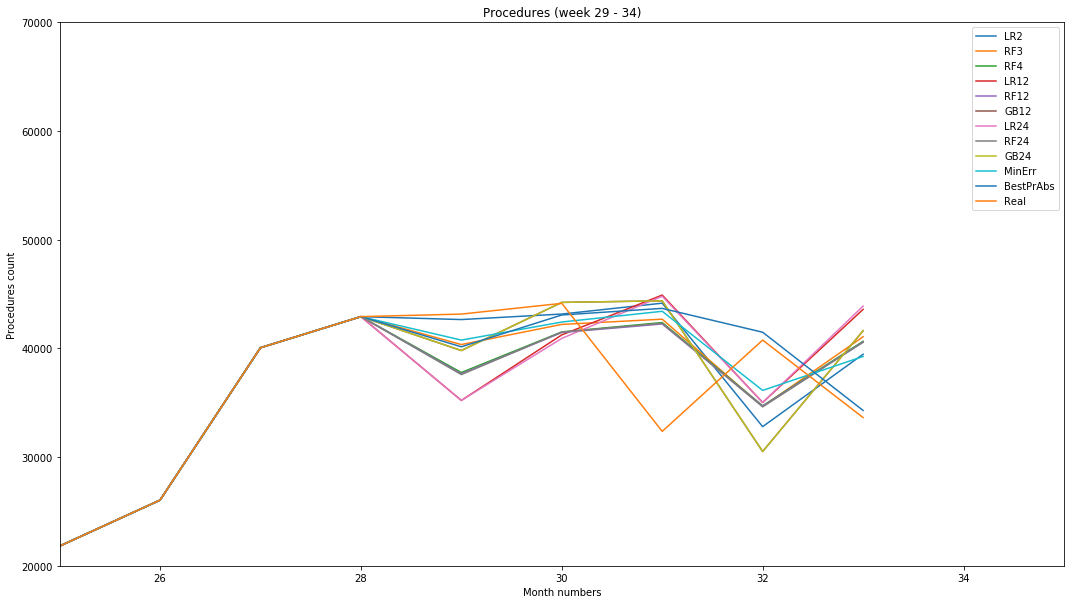

In [99]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(bestPredictPorc_er)
plt.plot(bestPredictPorc_AbsEr)
plt.plot(proceduresAll)

plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR2', 'RF3', 'RF4', 'LR12', 'RF12', 'GB12', 'LR24', 'RF24', 'GB24', 'MinErr', 'BestPrAbs', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 70000)

In [100]:
#Импортируем Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [117]:
B = pd.DataFrame({'B': predict_ProcB})
LR2 = pd.DataFrame({'LR2': predict_ProcLR2})
RF2 = pd.DataFrame({'RF2': predict_ProcRF3})
LGB2 = pd.DataFrame({'LGB2': predict_ProcRF3})
RF4 = pd.DataFrame({'RF4': predict_ProcRF4})
LR12 = pd.DataFrame({'LR12': predict_ProcLR12})
RF12 = pd.DataFrame({'RF12': predict_ProcRF12})
GB12 = pd.DataFrame({'GB12': predict_ProcGB12})
LR24 = pd.DataFrame({'LR24': predict_ProcLR24})
RF24 = pd.DataFrame({'RF24': predict_ProcRF24})
GB24 = pd.DataFrame({'GB24': predict_ProcGB24})

#BE = pd.DataFrame({'BE': bestPredictPorc_er})
BEST = pd.DataFrame({'BEST': bestPredictPorc_AbsEr})
REAL = pd.DataFrame({'REAL': proceduresAll})

In [118]:
B.reset_index(inplace=True)
LR2.reset_index(inplace=True)
RF2.reset_index(inplace=True)
LGB2.reset_index(inplace=True)
RF4.reset_index(inplace=True)
LR12.reset_index(inplace=True)
RF12.reset_index(inplace=True)
GB12.reset_index(inplace=True)
LR24.reset_index(inplace=True)
RF24.reset_index(inplace=True)
GB24.reset_index(inplace=True)
#BE.reset_index(inplace=True)
BEST.reset_index(inplace=True)
REAL.reset_index(inplace=True)

In [119]:
LR2=LR2.merge( B, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF2, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( LGB2, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF4, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( LR12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( GB12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( LR24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( GB24, how = 'inner', left_on = 'index', right_on = 'index' )
#LR2=LR2.merge( BE, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( BEST, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( REAL, how = 'inner', left_on = 'index', right_on = 'index' )


In [120]:
LR2 = LR2.tail(10)

In [122]:
#Строим графики
trace0 = go.Scatter(
    x=LR2.index,
    y=LR2.LR2,
    name='LR2'
)

trace1 = go.Scatter(
    x=LR2.index,
    y=LR2.RF2,
    name='RF2'
)

trace10 = go.Scatter(
    x=LR2.index,
    y=LR2.LGB2,
    name='LGB2'
)

trace2 = go.Scatter(
    x=LR2.index,
    y=LR2.RF4,
    name='RF4'
)

trace3 = go.Scatter(
    x=LR2.index,
    y=LR2.LR12,
    name='LR12'
)

trace4 = go.Scatter(
    x=LR2.index,
    y=LR2.RF12,
    name='RF12'
)

trace5 = go.Scatter(
    x=LR2.index,
    y=LR2.GB12,
    name='GB12'
)
trace6 = go.Scatter(
    x=LR2.index,
    y=LR2.LR24,
    name='LR24'
)

trace7 = go.Scatter(
    x=LR2.index,
    y=LR2.RF24,
    name='RF24'
)

trace8 = go.Scatter(
    x=LR2.index,
    y=LR2.GB24,
    name='GB24'
)
trace9 = go.Scatter(
    x=LR2.index,
    y=LR2.BEST,
    name='BEST'
)


trace11 = go.Scatter(
    x=LR2.index,
    y=LR2.REAL,
    name='REAL'
)

trace12 = go.Scatter(
    x=LR2.index,
    y=LR2.B,
    name='BASELINE'
)
data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9, trace10, trace12, trace11]
layout = {'title': 'Прогноз размещения (только регионы)'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)